In [2]:
# Imports
import os
import pickle

import numpy as np
import matplotlib.pyplot as plt
import scipy as sc
from scipy.stats import entropy
import pymc3


#import board

import time

# Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras.layers import Dense
import datetime
%load_ext tensorboard


from tqdm.notebook import tqdm

# Set plot params
plt.rc('font', size=18)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=18)    # fontsize of the tick labels
plt.rc('ytick', labelsize=18)    # fontsize of the tick labels
plt.rc('legend', fontsize=18)    # legend fontsize

/Users/kevinandersson/opt/miniconda3/envs/Physics-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/kevinandersson/opt/miniconda3/envs/Physics-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/kevinandersson/opt/miniconda3/envs/Physics-env/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

The tensorboard module is not an IPython extension.


In [3]:
start_time = time.time()
n = board.experiment()
print("--- %s seconds ---" % (time.time() - start_time))
print(n)
print(np.sum(n))

NameError: name 'board' is not defined

# Task 1: Simulator

In [4]:
nRows = 31

def simulator(alpha=0, s=0, n=1000):
    nslots = nRows+1 # Number of positions for marble in last row
    counts = np.zeros(nslots)
    
    nRight = np.zeros(n, dtype = int)
    M = np.zeros(n)
    
    rands = np.random.uniform(size = (n,nRows))

    for i in range(nRows):
        thres = 0.5 + alpha*M + s

        right = rands[:,i]<=thres
        nRight += right
        M = 0.5 - right

    for i in range(nslots):
        counts[i] = (nRight == i).sum()
        
    return counts

def simulator2(alpha=0, s=0, n=1000):
    
#     assert len(alpha) == len(s)
    alpha = alpha.reshape(-1,1)
    s = s.reshape(-1,1)
    
    nslots = nRows+1 # Number of positions for marble in last row
    counts = np.zeros((len(alpha), nslots))
    nRight = np.zeros((len(alpha), n), dtype = int)
    M = np.zeros((len(alpha), n))
    
    rands = np.random.uniform(size = (len(alpha),n,nRows))
    for i in range(nRows):
        thres = 0.5 + np.multiply(alpha,M) + s

        right = rands[:,:,i]<=thres
        nRight += right
        M = 0.5 - right

    for i in range(nslots):
        counts[:,i] = (nRight == i).sum(axis=1)
        
    return counts
   
alpha = 0.2
s = 0.1
start_time = time.time()
for i in range(1000):
    simulator(alpha, s, n=1000)
print("--- %s seconds ---" % (time.time() - start_time))


alpha = np.random.rand(1000)*0.2
s = np.random.rand(1000)*0.1
start_time = time.time()
counts = simulator2(alpha, s, n=1000)

print("--- %s seconds ---" % (time.time() - start_time))
print(counts.shape)
    

--- 0.9685046672821045 seconds ---
--- 1.0749709606170654 seconds ---
(1000, 32)


In [5]:
a = np.array([1,2,3,4])
b = np.random.uniform(size=(4,4))
print(b)
print(np.multiply(a.reshape(-1,1),b))
print(np.multiply(a.reshape(-1,1),b)+a.reshape(-1,1))

[[0.97042612 0.18705082 0.39694993 0.14167077]
 [0.31881685 0.04888215 0.59043897 0.07639474]
 [0.89954471 0.03569603 0.40395469 0.0901963 ]
 [0.4359956  0.81582941 0.795292   0.50467383]]
[[0.97042612 0.18705082 0.39694993 0.14167077]
 [0.6376337  0.0977643  1.18087794 0.15278949]
 [2.69863412 0.1070881  1.21186408 0.2705889 ]
 [1.74398241 3.26331763 3.181168   2.01869531]]
[[1.97042612 1.18705082 1.39694993 1.14167077]
 [2.6376337  2.0977643  3.18087794 2.15278949]
 [5.69863412 3.1070881  4.21186408 3.2705889 ]
 [5.74398241 7.26331763 7.181168   6.01869531]]


In [7]:
def gen_data(nData, alpha = None):
    alphaData = np.random.rand(nData)*0.5
    sData = np.random.rand(nData)*0.5 - 0.25
    y = np.zeros((nData, 2))
    X = np.zeros((nData, nRows+1))
    print(np.mean(alphaData))
    for i in tqdm(range(nData)):
        s = sData[i]
        y[i,1] = s
        if alpha != None:
            y[i,0] = alpha
            X[i,:] = simulator(alpha, s)
        else:
            a = alphaData[i]
            y[i,0] = a
            X[i,:] = simulator(a, s)     
    return X, y # return experiments and labels


n_data = 300000
data_file = f'saved_structures/train_data_n={n_data}.p'

if os.path.isfile(data_file):
    print('Loading pickled training data')
    data = pickle.load(open( data_file, "rb" ))
    X, y = data
else:
    print('Generating training data')
    X,y = gen_data(n_data)
    data = (X,y)
    pickle.dump(data, open(data_file, "wb"))

Loading pickled training data


# Task 2: NN

In [9]:
def nn_model(X):
    input_shape = (X.shape[1],)
    model = keras.Sequential()
    # model.add(keras.Input(shape=input_shape))
    model.add(layers.Dense(32, input_shape=input_shape, activation="relu", kernel_initializer='random_normal'))
#     model.add(layers.Dense(16, activation="relu", kernel_initializer='random_normal'))
#     model.add(layers.Dense(8, activation="relu", kernel_initializer='random_normal'))
    # model.add(layers.Dense(3, activation="relu"))
    model.add(layers.Dense(
              2,  
#               kernel_initializer=initializers.RandomNormal(stddev=0.01), 
#               bias_initializer=initializers.RandomNormal(mean=1.0, stddev=0.1)
              bias_initializer=initializers.Zeros()
    ))
    #opt = keras.optimizers.Adam(learning_rate=0.1)
    model.compile(loss='mean_squared_error', optimizer="adam", metrics=['mean_absolute_error'])
    return model
model = nn_model(X)
model.summary()

Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,122
Trainable params: 1,122
Non-trainable params: 0
_________________________________________________________________


In [11]:
model_file = f'saved_structures/nn_model_n={n_data}'
history_file = f'saved_structures/training_history_n={n_data}.p'

if os.path.exists(model_file) and os.path.isfile(history_file):
    print('Loading models and history')
    model = keras.models.load_model(model_file)
    mae_history = pickle.load(open( history_file, "rb" ))
    
else: 
    print('Training NN and saving model and history')
    log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
    history = model.fit(x=X/1000,
                        y=y,
                        epochs=200,
                        batch_size=1024,
                        validation_split=0.7,
                        verbose=0,
                        callbacks=[tensorboard_callback])
    model.save(model_file)
    mae_history = history.history
    pickle.dump(mae_history, open(history_file, "wb") )

Training NN and saving model and history
Instructions for updating:
Use tf.cast instead.


dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])
0.010527348


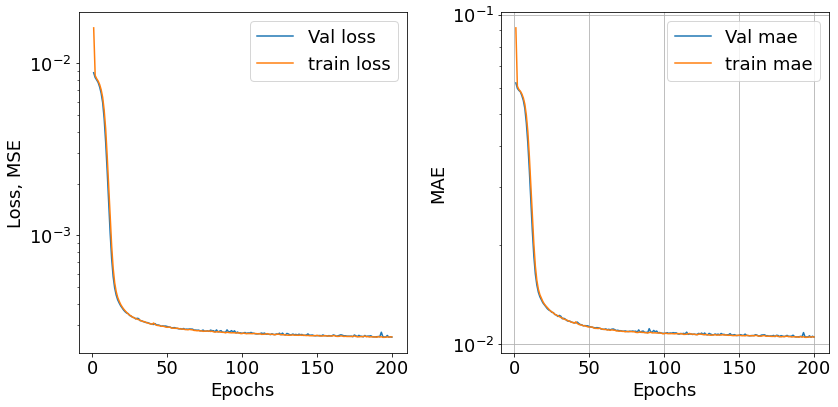

In [12]:
# Plot training history
print(mae_history.keys())
key = 'mean_absolute_error'
epochs = range(1, len(mae_history[key])+1)

fig, axs = plt.subplots(1, 2, figsize=(12,6))

axs[0].plot(epochs, mae_history['val_loss'], label='Val loss')
axs[0].plot(epochs, mae_history['loss'], label='train loss')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss, MSE')
axs[0].legend(loc='best')
axs[0].set_yscale('log')

axs[1].plot(epochs, mae_history['val_'+key], label='Val mae')
axs[1].plot(epochs, mae_history[key], label='train mae')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('MAE')
axs[1].legend(loc='best')
axs[1].set_yscale('log')
axs[1].grid()

plt.tight_layout()

print(mae_history['val_'+key][-1])

## Task3

0.24761791631599306



0.24940426507078348



0.022267986187756418 0.0045116963078621125
0.000574852010036125 0.0005048050537037357


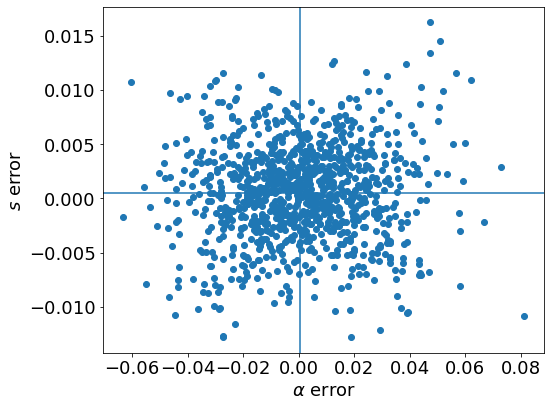

In [264]:
nData = 1000
    
y,labels = gen_data(nData)

theta = model.predict(y/1000)
error = theta - labels

alpha_mean = np.mean(error[:,0])
alpha_std = np.std(error[:,0])
s_mean = np.mean(error[:,1])
s_std = np.std(error[:,1])

y_obs,_ = gen_data(nData, alpha = 0.2)
print(alpha_std, s_std)
print(alpha_mean, s_mean)

fig, ax = plt.subplots(figsize=(8,6))
ax.scatter(x=error[:,0], y=error[:,1])
ax.axhline(s_mean)
ax.axvline(alpha_mean)
ax.set_xlabel(r'$\alpha$ error')
ax.set_ylabel(r'$s$ error')
plt.tight_layout()

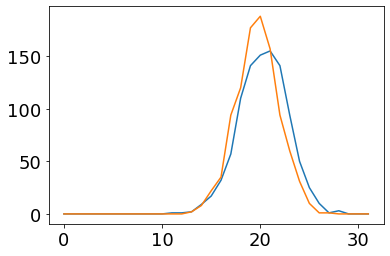

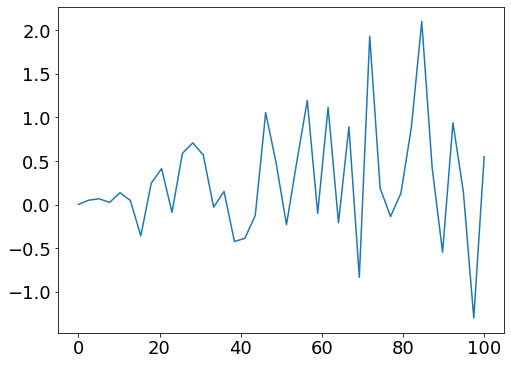

In [234]:
##         
y_ob = y_obs[90,:]
theta_m = model.predict(y_ob.reshape(1,32)/1000)[0]

s_m = theta_m[1]
alpha_m = theta_m[0]
s_star = np.random.normal(loc = s_m, scale  = s_std)

alpha_star = np.random.rand()*0.5
y_star = simulator(alpha_star, s_star)

plt.plot(y_star)
plt.plot(y_ob)

n = 40
theta_pred = np.zeros((n,2))
stds = np.linspace(0,100,n)
for i, std in enumerate(stds):
    y = y_ob + np.random.normal(size = 32 ,loc = 0, scale = std)
    theta_pred[i,:] = model.predict(y.reshape(1,32)/1000)[0]


fig,ax = plt.subplots(figsize = (8,6))
ax.plot(stds, theta_pred[:,0]-0.2)


In [265]:
def kernel(y, y_obs, h = 0.1, statistic = "KL"):
    if statistic == "KL":
        entrop = entropy(pk = y, qk = y_obs)
        x = entrop/h
    if statistic == "mean":
        grid = np.arange(0,32)
        x = ((y*grid).sum()-(y_obs*grid).sum())/(h*1000)
    if statistic == "euc":
        x = np.sqrt((y-y_obs).T@(y-y_obs))/(h*1000)
        
    if statistic == "NN":
        theta_obs = model.predict(y_obs.reshape(1,32)/1000)[0]
        theta = model.predict(y.reshape(1,32)/1000)[0]
        x = np.sqrt((theta - theta_obs).T@(theta - theta_obs))/h
        
    if statistic == "WSD":
        x = sc.stats.wasserstein_distance(y,y_obs)/h

    if statistic == "ED":
        x = sc.stats.energy_distance(y,y_obs)/h
    
    sigma = 1/np.sqrt(2*np.pi) # choose the 
    return np.exp(-x**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)


def ABC_MCMC(y_obs, gen_alpha = "prior", max_iter = 5, s_std = 0.01, alpha_std = 0.01):
    #gen_alpha = "NN"
    alpha = []
    for i, y_ob in tqdm(enumerate(y_obs)):

        theta_m = model.predict(y_ob.reshape(1,32)/1000)[0]
        s_m = theta_m[1]
        alpha_m = theta_m[0]
        
        for j in range(max_iter):
#             start_time = time.time()
            s_star = np.random.normal(loc = s_m, scale  = s_std)
            
            if gen_alpha == "NN":
                alpha_star = np.random.normal(loc = alpha_m, scale  = alpha_std)
                y_star = simulator(alpha_star, s_star)
                kern = kernel(y_star, y_ob)

                norm = sc.stats.norm(loc=alpha_m, scale = alpha_std)
                M1 = norm.pdf(0)
                M2 = norm.pdf(0.5)
                M = 2*max((1/M1,1/M2))*1
                M=1

                p_acc = kern*2/(M*norm.pdf(alpha_star))
                #print(p_acc, M, M1, M2)
                
            else:
                alpha_star = np.random.rand()*0.5
                
#                 start_time2 = time.time()
                y_star = simulator(alpha_star, s_star)
#                 print("--- %s seconds ---" % (time.time() - start_time2))
                
                kern = kernel(y_star, y_ob,h=0.05, statistic = "NN")
                p_acc = kern
#                 print(y_star)
#                 print(y_ob)
#                 print()
            
            if(np.random.rand() < p_acc):
                alpha.append(alpha_star)
                
#             print("--- %s seconds ---" % (time.time() - start_time))
    return np.array(alpha) 

alpha = ABC_MCMC(y_obs, s_std = s_std, alpha_std=alpha_std)
print(alpha.shape)
# print(alpha_star, s_star)

# print(p_acc)


(461,)


[0.13371553 0.26328112]


/Users/kevinandersson/opt/miniconda3/envs/Physics-env/lib/python3.7/site-packages/arviz/stats/stats.py:338: UserWarning: hpd will be deprecated Please replace hdi
  ("hpd will be deprecated " "Please replace hdi"),


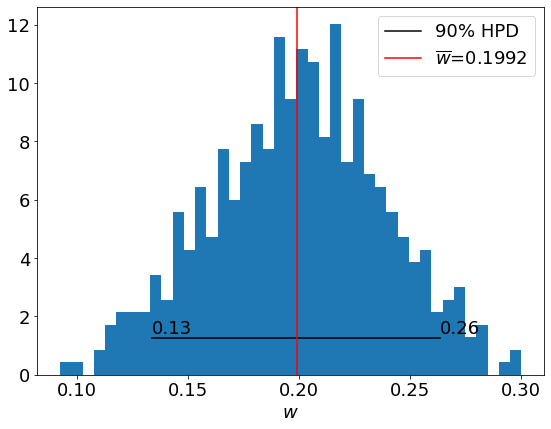

In [266]:
fig,ax = plt.subplots(figsize = (8,6))
ax.hist(alpha ,bins = 41, density = True)

hdi = pymc3.stats.hpd(alpha, 0.90)
print(hdi)
ymax = ax.get_ylim()[1]
ax.plot(hdi, [ymax/10, ymax/10], c='k', label='90% HPD')
ax.axvline(np.mean(alpha), c='r', label=r'$\overline{w}$'+f'={np.mean(alpha):.4f}')
ax.text(hdi[0], ymax/9, s=f'{hdi[0]:.2f}')
ax.text(hdi[1], ymax/9, s=f'{hdi[1]:.2f}')
plt.tight_layout()
ax.set_xlabel(r'$w$')
ax.legend(loc='best')
#plt.savefig('figures_task2/w_posterior.png')

Best result CI 0.14-0.26, max_iter = 1000, h = 0.05